In [3]:
# Cell 1: Install dependencies and clone Grounding DINO

import os
import urllib.request

# Install PyTorch first (CPU version for compatibility)
print("Installing PyTorch...")
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cpu

# Install other dependencies
print("Installing other dependencies...")
!pip install supervision transformers addict yapf timm pycocotools opencv-python

# Clone Grounding DINO repository if not already present
if not os.path.exists('GroundingDINO'):
    print("Cloning GroundingDINO repository...")
    !git clone https://github.com/IDEA-Research/GroundingDINO.git
else:
    print("GroundingDINO directory already exists, skipping clone...")

# Download the pre-trained model weights using Python
weights_dir = 'weights'
weights_path = os.path.join(weights_dir, 'groundingdino_swint_ogc.pth')

if not os.path.exists(weights_dir):
    os.makedirs(weights_dir)
    
if not os.path.exists(weights_path):
    print("Downloading model weights...")
    url = "https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth"
    urllib.request.urlretrieve(url, weights_path)
    print(f"✅ Weights downloaded to {weights_path}")
else:
    print(f"✅ Weights already exist at {weights_path}")

print("✅ Installation complete!")

Installing PyTorch...
Looking in indexes: https://download.pytorch.org/whl/cpu
Installing other dependencies...
GroundingDINO directory already exists, skipping clone...
✅ Weights downloaded to weights\groundingdino_swint_ogc.pth
✅ Installation complete!


In [4]:
# Cell 2: Import libraries and load model using Transformers

from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
from PIL import Image
import torch

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load model and processor from HuggingFace
print("Loading Grounding DINO model...")
model_id = "IDEA-Research/grounding-dino-tiny"
processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)

print("✅ Model loaded successfully!")
print(f"Model: {model_id}")
print("\nYou can now detect objects in your images!")
print("Example text prompts: 'person . car . dog' or 'cat . laptop . phone'")

Using device: cuda
Loading Grounding DINO model...
✅ Model loaded successfully!
Model: IDEA-Research/grounding-dino-tiny

You can now detect objects in your images!
Example text prompts: 'person . car . dog' or 'cat . laptop . phone'


Found 2 images in folder
Detection prompt: 'person'
------------------------------------------------------------

📸 front_001869.png
   Image size: (1920, 1280)
   Detected 11 objects:
     - person: 0.85 at [586.34, 639.24, 658.2, 834.31]
     - person: 0.78 at [1244.06, 610.5, 1281.19, 712.4]
     - person: 0.80 at [1361.07, 617.77, 1394.54, 711.41]
     - person: 0.55 at [1130.89, 622.36, 1149.8, 672.06]
     - person: 0.47 at [1484.83, 0.68, 1580.06, 81.73]
     - person: 0.38 at [395.68, 635.88, 416.76, 677.74]
     - person: 0.44 at [1211.05, 616.75, 1226.03, 679.72]
     - person: 0.33 at [1105.26, 615.08, 1120.74, 647.67]
     - person: 0.30 at [1080.67, 621.39, 1096.21, 659.73]
     - person: 0.28 at [1149.47, 627.76, 1165.18, 683.66]
     - person: 0.32 at [1184.41, 617.84, 1195.87, 666.01]


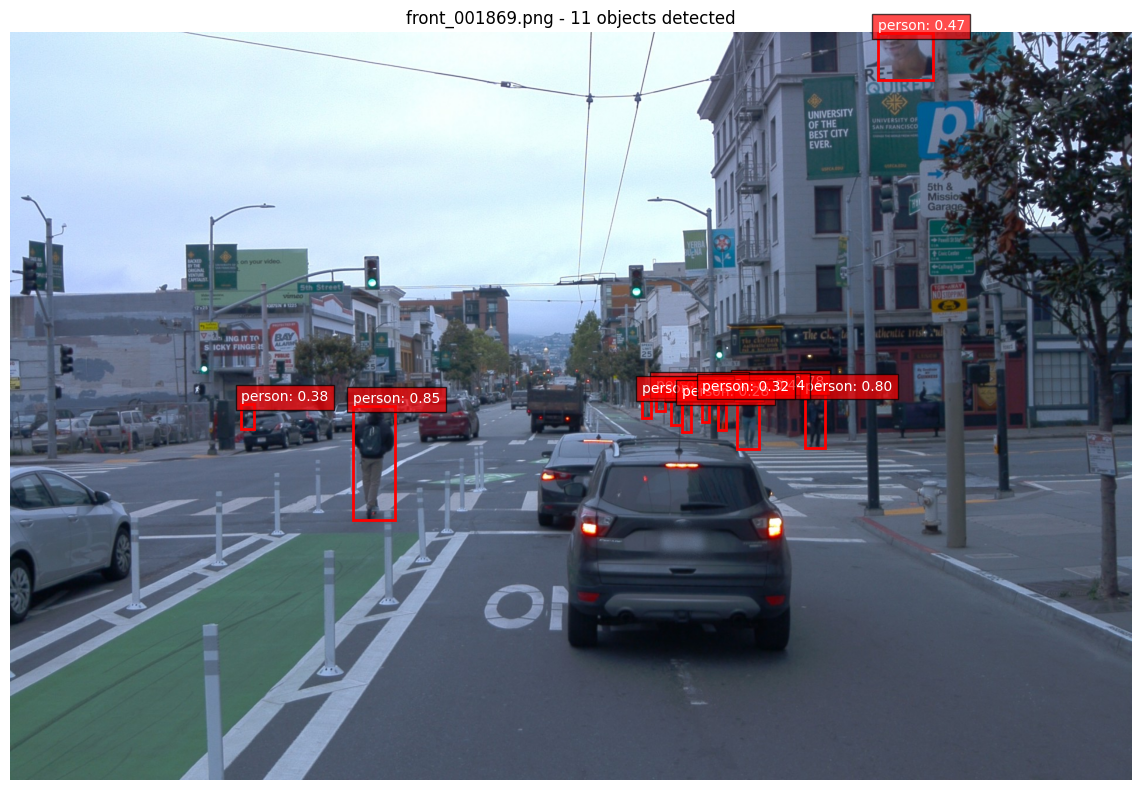


To process a specific image, use:
  detect_and_visualize(r'path/to/image.jpg', 'object1 . object2')


In [16]:
# Cell 3: Load and process images from your folder

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
from pathlib import Path

# Specify your folder path and detection prompt
image_folder = r"C:\Users\vnhar\Downloads\projects\thesis_prototype_3\test_images"
text_prompt = "person"  # Change this to what you want to detect

# Get all image files from the folder
image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.webp']
image_files = [f for f in os.listdir(image_folder) 
               if any(f.lower().endswith(ext) for ext in image_extensions)]

print(f"Found {len(image_files)} images in folder")
print(f"Detection prompt: '{text_prompt}'")
print("-" * 60)

# Function to process and visualize a single image
def detect_and_visualize(image_path, text_prompt, show_plot=True):
    # Load image
    image = Image.open(image_path)
    
    # Ensure prompt ends with a period
    if not text_prompt.strip().endswith('.'):
        text_prompt = text_prompt.strip() + ' .'
    
    # Run inference
    inputs = processor(images=image, text=text_prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Post-process results
    results = processor.post_process_grounded_object_detection(
        outputs,
        inputs.input_ids,
        threshold=0.25,  # Adjust confidence threshold (lower = more detections)
        target_sizes=[image.size[::-1]]
    )
    
    # Extract results
    boxes = results[0]["boxes"].cpu()
    scores = results[0]["scores"].cpu()
    labels = results[0]["labels"]
    
    # Print results
    print(f"\n📸 {os.path.basename(image_path)}")
    print(f"   Image size: {image.size}")
    print(f"   Detected {len(boxes)} objects:")
    for score, label, box in zip(scores, labels, boxes):
        box_coords = [round(i, 2) for i in box.tolist()]
        print(f"     - {label}: {score:.2f} at {box_coords}")
    
    # Visualize if requested
    if show_plot:
        fig, ax = plt.subplots(1, figsize=(12, 8))
        ax.imshow(image)
        
        for box, score, label in zip(boxes, scores, labels):
            x1, y1, x2, y2 = box
            width = x2 - x1
            height = y2 - y1
            
            # Draw bounding box
            rect = patches.Rectangle((x1, y1), width, height, 
                                    linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)
            
            # Add label with confidence
            ax.text(x1, y1-5, f'{label}: {score:.2f}', 
                   bbox=dict(facecolor='red', alpha=0.7), 
                   fontsize=10, color='white')
        
        ax.set_title(f"{os.path.basename(image_path)} - {len(boxes)} objects detected")
        ax.axis('off')
        plt.tight_layout()
        plt.show()
    
    return boxes, scores, labels

# Process first image as example
if image_files:
    first_image_path = os.path.join(image_folder, image_files[0])
    detect_and_visualize(first_image_path, text_prompt)
else:
    print("⚠️ No images found in the folder!")
    
print("\n" + "="*60)
print("To process a specific image, use:")
print("  detect_and_visualize(r'path/to/image.jpg', 'object1 . object2')")

In [17]:
# Cell 3: Interactive image selection and detection

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
from pathlib import Path

# Specify your folder path
image_folder = r"C:\Users\vnhar\Downloads\projects\thesis_prototype_3\test_images"

# Get all image files from the folder
image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.webp']
image_files = [f for f in os.listdir(image_folder) 
               if any(f.lower().endswith(ext) for ext in image_extensions)]

print(f"Found {len(image_files)} images in folder:")
print("="*60)
for i, img_file in enumerate(image_files):
    print(f"  [{i}] {img_file}")
print("="*60)

# Function to process and visualize a single image
def detect_and_visualize(image_path, text_prompt, show_plot=True):
    # Load image
    image = Image.open(image_path)
    
    # Ensure prompt ends with a period
    if not text_prompt.strip().endswith('.'):
        text_prompt = text_prompt.strip() + ' .'
    
    print(f"\n🔍 Processing: {os.path.basename(image_path)}")
    print(f"   Prompt: '{text_prompt}'")
    
    # Run inference
    inputs = processor(images=image, text=text_prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Post-process results
    results = processor.post_process_grounded_object_detection(
        outputs,
        inputs.input_ids,
        threshold=0.25,  # Adjust confidence threshold (lower = more detections)
        target_sizes=[image.size[::-1]]
    )
    
    # Extract results
    boxes = results[0]["boxes"].cpu()
    scores = results[0]["scores"].cpu()
    labels = results[0]["labels"]
    
    # Print results
    print(f"   Image size: {image.size}")
    print(f"   ✅ Detected {len(boxes)} objects:")
    for score, label, box in zip(scores, labels, boxes):
        box_coords = [round(i, 2) for i in box.tolist()]
        print(f"     - {label}: {score:.2f} at {box_coords}")
    
    # Visualize if requested
    if show_plot:
        fig, ax = plt.subplots(1, figsize=(14, 10))
        ax.imshow(image)
        
        for box, score, label in zip(boxes, scores, labels):
            x1, y1, x2, y2 = box
            width = x2 - x1
            height = y2 - y1
            
            # Draw bounding box
            rect = patches.Rectangle((x1, y1), width, height, 
                                    linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)
            
            # Add label with confidence
            ax.text(x1, y1-5, f'{label}: {score:.2f}', 
                   bbox=dict(facecolor='red', alpha=0.7), 
                   fontsize=10, color='white')
        
        ax.set_title(f"{os.path.basename(image_path)} - {len(boxes)} objects detected", 
                    fontsize=14, fontweight='bold')
        ax.axis('off')
        plt.tight_layout()
        plt.show()
    
    return boxes, scores, labels

# Interactive selection
print("\nTo process an image, use:")
print("  image_index = 0  # Select image number from list above")
print("  text_prompt = 'car . person . tree'  # What to detect")
print("  selected_image = os.path.join(image_folder, image_files[image_index])")
print("  detect_and_visualize(selected_image, text_prompt)")
print("\nOr run the code in Cell 4 for quick selection!")

Found 2 images in folder:
  [0] front_001869.png
  [1] front_004910.png

To process an image, use:
  image_index = 0  # Select image number from list above
  text_prompt = 'car . person . tree'  # What to detect
  selected_image = os.path.join(image_folder, image_files[image_index])
  detect_and_visualize(selected_image, text_prompt)

Or run the code in Cell 4 for quick selection!



🔍 Processing: front_004910.png
   Prompt: 'car .'
   Image size: (1920, 1280)
   ✅ Detected 11 objects:
     - car: 0.70 at [0.21, 750.07, 220.01, 1010.28]
     - car: 0.64 at [553.96, 703.39, 681.37, 792.84]
     - car: 0.63 at [304.25, 695.47, 485.0, 808.44]
     - car: 0.61 at [670.47, 701.15, 747.15, 763.63]
     - car: 0.57 at [735.09, 685.13, 796.63, 738.51]
     - car: 0.47 at [240.49, 709.12, 344.9, 796.1]
     - car: 0.44 at [794.97, 690.91, 824.07, 727.14]
     - car: 0.32 at [798.42, 671.26, 845.68, 721.55]
     - car: 0.27 at [913.2, 673.48, 951.94, 712.8]
     - car: 0.25 at [0.34, 694.92, 176.43, 787.07]
     - car: 0.28 at [816.47, 685.59, 846.24, 721.18]


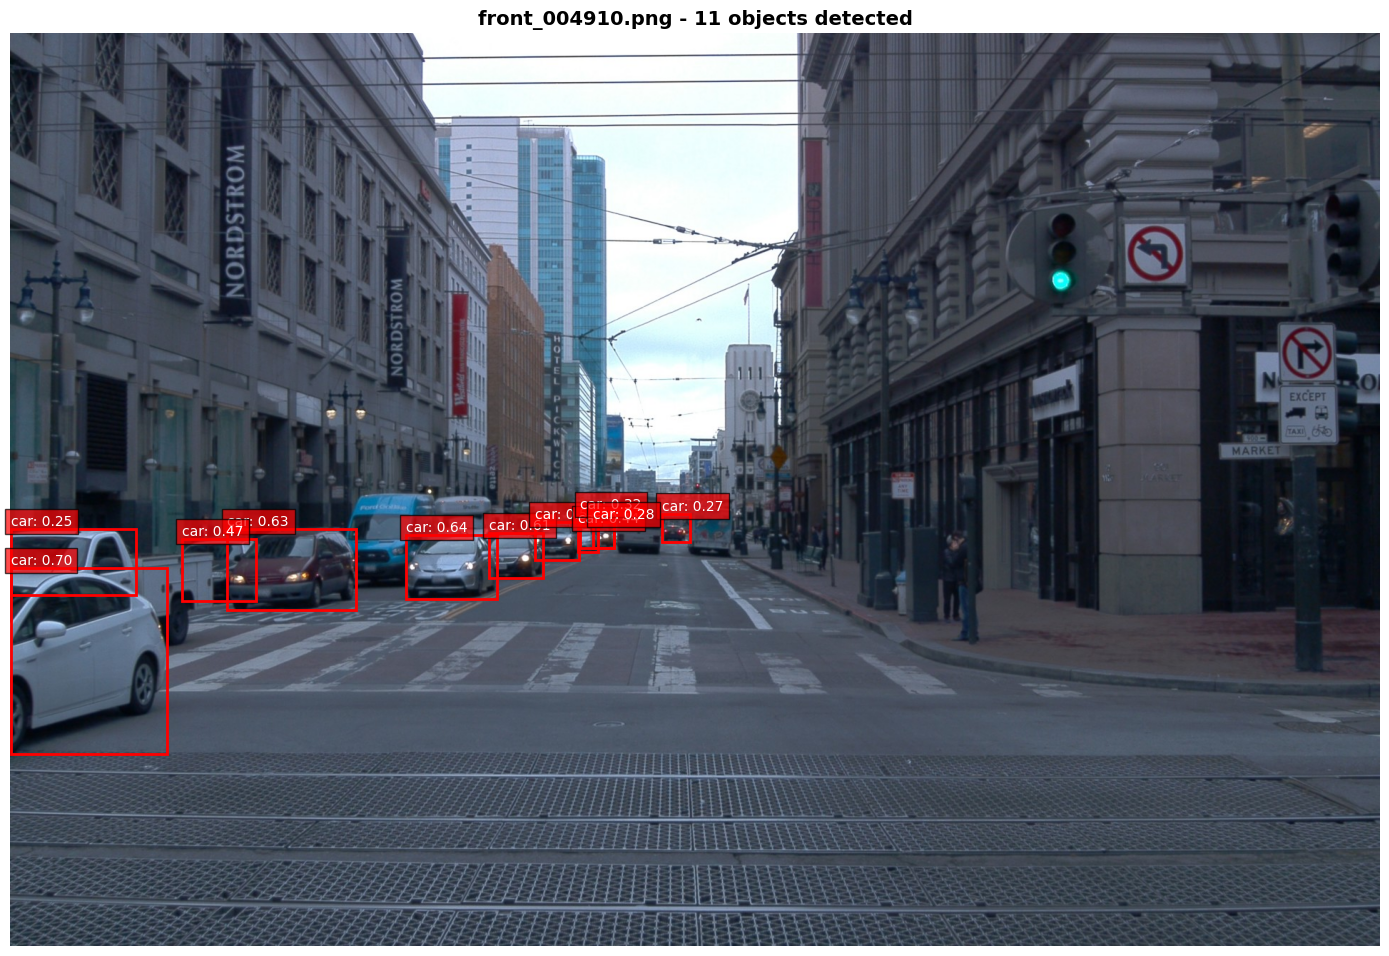

(tensor([[2.0963e-01, 7.5007e+02, 2.2001e+02, 1.0103e+03],
         [5.5396e+02, 7.0339e+02, 6.8137e+02, 7.9284e+02],
         [3.0425e+02, 6.9547e+02, 4.8500e+02, 8.0844e+02],
         [6.7047e+02, 7.0115e+02, 7.4715e+02, 7.6363e+02],
         [7.3509e+02, 6.8513e+02, 7.9663e+02, 7.3851e+02],
         [2.4049e+02, 7.0912e+02, 3.4490e+02, 7.9610e+02],
         [7.9497e+02, 6.9091e+02, 8.2407e+02, 7.2714e+02],
         [7.9842e+02, 6.7126e+02, 8.4568e+02, 7.2155e+02],
         [9.1320e+02, 6.7348e+02, 9.5194e+02, 7.1280e+02],
         [3.3942e-01, 6.9492e+02, 1.7643e+02, 7.8707e+02],
         [8.1647e+02, 6.8559e+02, 8.4624e+02, 7.2118e+02]]),
 tensor([0.6977, 0.6443, 0.6343, 0.6138, 0.5745, 0.4726, 0.4387, 0.3227, 0.2692,
         0.2518, 0.2755]),
 ['car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car'])

In [18]:
# Cell 4: Quick image selection and detection

# SELECT IMAGE (change the number based on the list above)
image_index = 1  # Change this number to select different images

# ENTER YOUR TEXT PROMPT (what objects to detect)
text_prompt = "car"  # Change this to what you want to detect

# Process the selected image
selected_image = os.path.join(image_folder, image_files[image_index])
detect_and_visualize(selected_image, text_prompt)

In [27]:
# Cell 5: Video object detection

import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import clear_output
import os
import re  # <-- Added for cleaning prompt text

# Specify your video folder path
video_folder = r"C:\Users\vnhar\Downloads\projects\thesis_prototype_2\data\video\training"

# Specify your output video folder path
output_folder = r"C:\Users\vnhar\Downloads\projects\thesis_prototype_3\output_video"
os.makedirs(output_folder, exist_ok=True)

# Get all video files from the folder
video_extensions = ['.mp4', '.avi', '.mov', '.mkv', '.webm']
video_files = [f for f in os.listdir(video_folder) 
               if any(f.lower().endswith(ext) for ext in video_extensions)]

print(f"Found {len(video_files)} videos in folder:")
print("="*60)
for i, vid_file in enumerate(video_files):
    print(f"  [{i}] {vid_file}")
print("="*60)


def detect_in_video(video_path, text_prompt, 
                    frame_interval=30, max_frames=None, 
                    save_output=False, output_path=None):
    """
    Process video and detect objects in frames
    
    Args:
        video_path: Path to video file
        text_prompt: Objects to detect (e.g., "car . person")
        frame_interval: Process every Nth frame (default: 30 = ~1 per second at 30fps)
        max_frames: Maximum number of frames to process (None = all)
        save_output: Whether to save annotated video
        output_path: Where to save output video
    """
    
    # Ensure prompt ends with period
    if not text_prompt.strip().endswith('.'):
        text_prompt = text_prompt.strip() + ' .'
    
    # Clean text prompt for filename
    clean_prompt = re.sub(r'[^a-zA-Z0-9_]', '_', text_prompt.strip())  # replace invalid chars
    clean_prompt = re.sub(r'_+', '_', clean_prompt).strip('_')  # remove duplicates
    
    # Open video
    cap = cv2.VideoCapture(video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    print(f"\n🎥 Video: {os.path.basename(video_path)}")
    print(f"   Resolution: {width}x{height}")
    print(f"   FPS: {fps}")
    print(f"   Total frames: {total_frames}")
    print(f"   Duration: {total_frames/fps:.2f} seconds")
    print(f"   Processing every {frame_interval} frames")
    print(f"   Detection prompt: '{text_prompt}'")
    print("="*60)
    
    # Setup video writer if saving
    if save_output:
        if output_path is None:
            video_name = os.path.splitext(os.path.basename(video_path))[0]
            output_name = f"{video_name}_{clean_prompt}_detected.mp4"
            output_path = os.path.join(output_folder, output_name)
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    frame_count = 0
    processed_count = 0
    all_detections = []
    
    try:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            
            # Process every Nth frame
            if frame_count % frame_interval == 0:
                # Convert BGR to RGB
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                image = Image.fromarray(frame_rgb)
                
                # Run detection
                inputs = processor(images=image, text=text_prompt, return_tensors="pt").to(device)
                with torch.no_grad():
                    outputs = model(**inputs)
                
                results = processor.post_process_grounded_object_detection(
                    outputs,
                    inputs.input_ids,
                    threshold=0.25,
                    target_sizes=[image.size[::-1]]
                )
                
                boxes = results[0]["boxes"].cpu()
                scores = results[0]["scores"].cpu()
                labels = results[0]["labels"]
                
                # Draw boxes on frame
                for box, score, label in zip(boxes, scores, labels):
                    x1, y1, x2, y2 = map(int, box.tolist())
                    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)
                    text = f"{label}: {score:.2f}"
                    cv2.putText(frame, text, (x1, y1-10), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
                
                processed_count += 1
                all_detections.append({
                    'frame': frame_count,
                    'time': frame_count/fps,
                    'objects': len(boxes),
                    'labels': labels
                })
                
                print(f"Frame {frame_count}/{total_frames} ({frame_count/fps:.2f}s): {len(boxes)} objects detected")
                
                if max_frames and processed_count >= max_frames:
                    print(f"\n⚠️ Reached max_frames limit ({max_frames})")
                    break
            
            # Write frame
            if save_output:
                out.write(frame)
            
            frame_count += 1
        
    finally:
        cap.release()
        if save_output:
            out.release()
            print(f"\n✅ Output saved to: {output_path}")
    
    print(f"\n✅ Processing complete!")
    print(f"   Processed {processed_count} frames")
    print(f"   Total objects detected: {sum(d['objects'] for d in all_detections)}")
    
    return all_detections


# Instructions
print("\nTo process a video, use:")
print("  video_index = 0  # Select video number")
print("  text_prompt = 'car . person . tree'")
print("  video_path = os.path.join(video_folder, video_files[video_index])")
print("  results = detect_in_video(video_path, text_prompt, frame_interval=30, save_output=True)")


Found 26 videos in folder:
  [0] segment-10017090168044687777_6380_000_6400_000_with_camera_labels_front.mp4
  [1] segment-10023947602400723454_1120_000_1140_000_with_camera_labels_front.mp4
  [2] segment-1005081002024129653_5313_150_5333_150_with_camera_labels_front.mp4
  [3] segment-10061305430875486848_1080_000_1100_000_with_camera_labels_front.mp4
  [4] segment-10072140764565668044_4060_000_4080_000_with_camera_labels_front.mp4
  [5] segment-10072231702153043603_5725_000_5745_000_with_camera_labels_front.mp4
  [6] segment-10075870402459732738_1060_000_1080_000_with_camera_labels_front.mp4
  [7] segment-10082223140073588526_6140_000_6160_000_with_camera_labels_front.mp4
  [8] segment-10094743350625019937_3420_000_3440_000_with_camera_labels_front.mp4
  [9] segment-10096619443888687526_2820_000_2840_000_with_camera_labels_front.mp4
  [10] segment-10107710434105775874_760_000_780_000_with_camera_labels_front.mp4
  [11] segment-10153695247769592104_787_000_807_000_with_camera_labels_fr

In [30]:
# Cell 6: Quick video selection and processing

# SELECT VIDEO (change the number based on the list above)
video_index = 22  # Change this to select different video

# ENTER YOUR TEXT PROMPT
text_prompt = "car . person"  # What objects to detect

# PROCESSING OPTIONS
frame_interval = 1  # Process every 30 frames (1 frame per second at 30fps)
max_frames = None  # Limit to first 10 processed frames (set to None for entire video)
save_output = True  # Save annotated video?

# Process the video
video_path = os.path.join(video_folder, video_files[video_index])
results = detect_in_video(
    video_path, 
    text_prompt, 
    frame_interval=frame_interval,
    max_frames=max_frames,
    save_output=save_output
)

# Show summary
print("\n" + "="*60)
print("DETECTION SUMMARY:")
for r in results:
    print(f"  Time {r['time']:.2f}s: {r['objects']} objects - {', '.join(set(r['labels']))}")


🎥 Video: segment-10444454289801298640_4360_000_4380_000_with_camera_labels_front.mp4
   Resolution: 1920x1280
   FPS: 10
   Total frames: 199
   Duration: 19.90 seconds
   Processing every 1 frames
   Detection prompt: 'car . person .'


c:\Users\vnhar\Downloads\projects\.venv\Lib\site-packages\transformers\models\grounding_dino\processing_grounding_dino.py:93: FutureWarning: The key `labels` is will return integer ids in `GroundingDinoProcessor.post_process_grounded_object_detection` output since v4.51.0. Use `text_labels` instead to retrieve string object names.
  warnings.warn(self.message, FutureWarning)


Frame 0/199 (0.00s): 9 objects detected
Frame 1/199 (0.10s): 10 objects detected
Frame 2/199 (0.20s): 12 objects detected
Frame 3/199 (0.30s): 15 objects detected
Frame 4/199 (0.40s): 19 objects detected
Frame 5/199 (0.50s): 18 objects detected
Frame 6/199 (0.60s): 19 objects detected
Frame 7/199 (0.70s): 19 objects detected
Frame 8/199 (0.80s): 23 objects detected
Frame 9/199 (0.90s): 21 objects detected
Frame 10/199 (1.00s): 21 objects detected
Frame 11/199 (1.10s): 19 objects detected
Frame 12/199 (1.20s): 14 objects detected
Frame 13/199 (1.30s): 17 objects detected
Frame 14/199 (1.40s): 17 objects detected
Frame 15/199 (1.50s): 19 objects detected
Frame 16/199 (1.60s): 19 objects detected
Frame 17/199 (1.70s): 19 objects detected
Frame 18/199 (1.80s): 23 objects detected
Frame 19/199 (1.90s): 21 objects detected
Frame 20/199 (2.00s): 25 objects detected
Frame 21/199 (2.10s): 26 objects detected
Frame 22/199 (2.20s): 26 objects detected
Frame 23/199 (2.30s): 28 objects detected
Fra